$$\Huge \text{RAPORT}$$
$$\huge \text{LISTA 2}$$
$$\large \text{Autorzy: Katarzyna Rudzińska, Jagoda Płócienniczak}$$

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, fisher_exact, kendalltau, beta, chi2  
import numpy.linalg as linalg
import os

In [161]:
# np.set_printoptions(legacy='1.25')

Niniejszy raport stanowi kontynuację analizy opinii pracowników na temat szkoleń organizowanych przez firmę, rozpoczętej w poprzednim opracowaniu. Główna część analizy dotyczy oceny skuteczności szkolenia „Efektywna komunikacja w zespole” oraz identyfikacji czynników demograficznych (takich jak płeć, wiek czy staż pracy), które mogą mieć wpływ na poziom zadowolenia uczestników. W dalszej części przeprowadzono testy statystyczne służące weryfikacji hipotez dotyczących rozkładów odpowiedzi oraz zależności pomiędzy zmiennymi. Zastosowano między innymi testy chi-kwadrat, testy Fishera oraz testy Freemana-Haltona.

Ze względu na fakt, iż przeprowadzona analiza obejmuje rozwiązanie zadań podzielonych na pięć głównych części, a w niektórych z nich odwołano się do wcześniej zdefiniowanych pojęć i zmiennych z poprzedniego raportu, ich implementacja została powtórzona również w niniejszym opracowaniu. Pozwala to na zachowanie spójności analizy oraz zapewnia pełną czytelność bieżącego raportu.

In [162]:
data = pd.read_csv('ankieta.csv', encoding='Windows-1250', sep=';')
data['DZIAŁ'] = data['DZIAŁ'].astype("category")
data['CZY_KIER'] = data['CZY_KIER'].astype("category")
data['PŁEĆ'] = data['PŁEĆ'].astype("category")

In [163]:
def categorize_age(age):
    if age <= 35:
        return "<=35"
    elif 36 <= age <= 45:
        return "36-45"
    elif 46 <= age <= 55:
        return "46-55"
    else:
        return ">55"

data["WIEK_KAT"] = data["WIEK"].apply(categorize_age)
data['WIEK_KAT'] = data['WIEK_KAT'].astype("category")

In [164]:
def is_satisfied(satisfaction_lvl):
    if satisfaction_lvl == -2 or satisfaction_lvl == -1:
        return 'NIE'
    else:
        return 'TAK'

data["CZY_ZADOW"] = data["PYT_2"].apply(is_satisfied)
data["CZY_ZADOW"] = data["CZY_ZADOW"].astype("category")

## CZĘŚĆ I

### ZADANIE 1
    W ankiecie przedstawionej na poprzedniej liście pracownicy zostali poproszeni o wyrażenie opinii na temat skuteczności szkolenia "Efektywna komunikacja w zespole" zorganizowanego przez firmę. Wśród próbki 200 pracowników (losowanie proste ze zwracaniem) uzyskano wyniki:
        • 14 pracowników - bardzo niezadowolonych,
        • 17 pracowników - niezadowolonych,
        • 40 pracowników - nie ma zdania,
        • 100 pracowników - zadowolonych,
        • 29 pracowników - bardzo zadowolonych,
    Na podstawie danych wyznacz przedział ufności dla wektora prawodobieństw opisującego stopień zadowolenia ze szkolenia. Przyjmij poziom ufności 0,95.

In [165]:
n = 200
counts = np.array([14, 17, 40, 100, 29])
labels = ["bardzo niezadowoleni", "niezadowoleni", "neutralni", "zadowoleni", "bardzo zadowoleni"]
proportions = counts / n
alpha = 0.05

ci_lower = []
ci_upper = []

for x in counts:
    lower = beta.ppf(alpha / 2, x, n - x + 1)
    upper = beta.ppf(1 - alpha / 2, x + 1, n - x)
    ci_lower.append(lower)
    ci_upper.append(upper)

ci_df = pd.DataFrame({
    "Kategoria": labels,
    "Liczba": counts,
    "Proporcja": proportions,
    "Dolna granica CI": ci_lower,
    "Górna granica CI": ci_upper
})

ci_df = ci_df.round(4)
ci_df

,Kategoria,Liczba,Proporcja,Dolna granica CI,Górna granica CI
0,bardzo niezadowoleni,14,0.070,0.0388,0.1147
1,niezadowoleni,17,0.085,0.0503,0.1326
2,neutralni,40,0.200,0.1469,0.2622
3,zadowoleni,100,0.500,0.4287,0.5713
4,bardzo zadowoleni,29,0.145,0.0993,0.2016


Na podstawie próby 200 pracowników oszacowano proporcje ocen szkolenia „Efektywna komunikacja w zespole” w pięciu kategoriach. Dla każdej kategorii wyznaczono 95% przedział ufności metodą Cloppera-Pearsona, co pozwala oszacować niepewność tych proporcji w populacji wszystkich pracowników.

Najwięcej osób zadeklarowało, że są **zadowoleni** (50% próby), a ich przedział ufności to (42.87%, 57.13%). Drugą najliczniejszą grupą byli pracownicy **neutralni** (20%, CI: 14.69%, 26.22%). Stosunkowo niewielki odsetek osób był **bardzo niezadowolony** (7%) lub **niezadowolony** (8.5%).Przedziały te informują nas, że z 95% pewnością prawdziwe proporcje ocen w całej populacji znajdują się w wyznaczonych granicach. Największa niepewność dotyczy skrajnych kategorii (bardzo niezadowoleni i bardzo zadowoleni), co wynika z mniejszej liczby obserwacji w tych grupach.

### ZADANIE 2 
    Napisz funkcję, która wyznacza wartość poziomu krytycznego w następujących testach:
        • chi-kwadrat Pearsona
        • chi-kwadrat największej wiarogodności
    służących do weryfikacji hipotezy H0 : p = p0 przy hipotezie alternatywnej H1 : p = p0 na podstawie obserwacji x wektora losowego X z rozkładu wielomianowego z parametrami n i p.

In [166]:
def test_chi_squared(x, p0, n):
    """
    Wykonuje test chi-kwadrat Pearsona oraz test ilorazu wiarygodności dla sprawdzenia zgodności rozkładu empirycznego z rozkładem teoretycznym.

    Parametry:
    x : array_like
        Wektory zliczeń empirycznych (liczby obserwowane w każdej kategorii).
    p0 : array_like
        Wektor teoretycznych prawdopodobieństw dla każdej kategorii (musi sumować się do 1).
    n : int
        Łączna liczba obserwacji (czyli suma elementów wektora `x`).

    Zwraca
       dict
        Słownik zawierający wyniki obu testów:
        - 'Pearson chi^2': wartość statystyki chi-kwadrat Pearsona
        - 'Pearson p-value': wartość p dla testu Pearsona
        - 'Likelihood ratio chi^2': wartość statystyki testu ilorazu wiarygodności (G-test)
        - 'Likelihood ratio p-value': wartość p dla G-testu

    Wyjątki
    ValueError
        Jeśli `p0` nie sumuje się do 1 lub jeśli suma `x` nie równa się `n`.
        """
    
    x = np.array(x)
    p0 = np.array(p0)

    if not np.isclose(np.sum(p0), 1):
        raise ValueError("Rozkład p0 musi sumować się do 1.")
    if not np.isclose(np.sum(x), n):
        raise ValueError("Suma obserwacji x musi być równa n.")
    
    expected = n * p0
    mask = expected > 0
    df = np.count_nonzero(mask) - 1

    chi2_pearson = np.sum((x[mask] - expected[mask]) ** 2 / expected[mask])
    p_pearson = 1 - chi2.cdf(chi2_pearson, df)

    with np.errstate(divide='ignore', invalid='ignore'):
        terms = np.where(x != 0, x * np.log(x / expected), 0)
    chi2_likelihood = 2 * np.sum(terms)
    p_likelihood = 1 - chi2.cdf(chi2_likelihood, df)

    return {
        "Pearson chi^2": chi2_pearson,
        "Pearson p-value": p_pearson,
        "Likelihood ratio chi^2": chi2_likelihood,
        "Likelihood ratio p-value": p_likelihood
    }

W zadaniu rozważamy dwa testy statystyczne służące do weryfikacji hipotezy zerowej $ H_0: p = p_0 $, gdzie $ p $ to nieznany wektor prawdopodobieństw rozkładu wielomianowego, a $ p_0 $ to hipotetyczny (zadany) rozkład teoretyczny. Oba testy opierają się na porównaniu zaobserwowanych liczności $ x = (x_1, \ldots, x_k) $ z licznościami oczekiwanymi $ E = n \cdot p_0 $, gdzie $ n $ to liczność próby.

#### 1. Test chi-kwadrat Pearsona

Statystyka testowa Pearsona dana jest wzorem:
$
\chi^2_P = \sum_{i=1}^k \dfrac{(x_i - E{i})^2}{E_{i}}
$

Wartość tej statystyki porównuje się z rozkładem chi-kwadrat o $ k-1 $ stopniach swobody. Jeżeli obliczona statystyka przekracza wartość krytyczną, odrzucamy hipotezę zerową.

#### 2. Test chi-kwadrat największej wiarygodności (test log-likelihood ratio)

Drugi test oparty jest na statystyce logarytmu stosunku wiarygodności (likelihood ratio):
$
\chi^2_{LR} = 2 \sum_{i=1}^k x_i \ln\left( \dfrac{x_i}{E_{i}} \right)
$
z konwencją, że $ 0 \cdot \ln(0) = 0 $. Podobnie jak w teście Pearsona, ta statystyka ma asymptotycznie rozkład chi-kwadrat z $ k - 1 $ stopniami swobody.


### Przykład użycia

In [167]:
x = [14, 17, 40, 100, 29]
n = sum(x)
p0 = [0.1, 0.1, 0.2, 0.5, 0.1]  

test_chi_squared(x, p0, n)

{'Pearson chi^2': np.float64(6.3),
 'Pearson p-value': np.float64(0.1778363264982168),
 'Likelihood ratio chi^2': np.float64(6.038144239875159),
 'Likelihood ratio p-value': np.float64(0.1963176909242157)}

W obu przypadkach wartości p są większe niż typowy poziom istotności $\alpha$= 0.05.
Oznacza to, że brak podstaw do odrzucenia hipotezy zerowej. Można zatem uznać, że nie ma statystycznie istotnych różnic między rozkładem empirycznym a teoretycznym  $p_0$

### ZADANIE 3
    Na podstawie danych z ankiety z poprzedniej listy zweryfikuj hipotezę, że w grupie pracowników zatrudnionwych w Dziale Produktowym rozkład odpowiedzi na pytanie "Jak bardzo zgadzasz się ze stwierdzeniem, że firma zapewnia odpowiednie wsparcie i materiały umożliwiające skuteczne wykorzystanie w praktyce wiedzy zdobytej w trakcie szkoleń?" jest równomierny, tzn. jest jednakowe prawdopodobieństwo, że pracownik zatrudniony w Dziale Produkcjnym udzielił odpowiedzi "zdecydowanie się nie zgadzam", "nie zgadzam się", "nie mam zdania", "zgadzam się", "zdecydowanie się zgadzam" na pytanie PYT_1. Przyjmij poziom istotności 0,05. Skorzystaj z funkcji napisanej w zadaniu 2.

In [168]:
df_pd = data[data["DZIAŁ"] == "PD"]
df_pd = df_pd.copy()


odpowiedzi_map = {
    -3: "zdecydowanie się nie zgadzam",
    -2: "nie zgadzam się",
    -1: "nie mam zdania",
     0: "zgadzam się",
     1: "zdecydowanie się zgadzam"
}

kategorie = [
    "zdecydowanie się nie zgadzam",
    "nie zgadzam się",
    "nie mam zdania",
    "zgadzam się",
    "zdecydowanie się zgadzam"
]

df_pd["PYT_1_opis"] = df_pd["PYT_1"].map(odpowiedzi_map)

x = df_pd["PYT_1_opis"].value_counts().reindex(kategorie, fill_value=0).values
n = x.sum()
p0 = [1/5] * 5

wynik = test_chi_squared(x, p0, n)

for nazwa, wartosc in wynik.items():
    print(f"{nazwa}: {wartosc:}")


Pearson chi^2: 89.4942528735632
Pearson p-value: 0.0
Likelihood ratio chi^2: 85.95139660536131
Likelihood ratio p-value: 0.0


Do testowania tej hipotezy zastosowano testy zgodności: test chi-kwadrat Pearsona oraz test największej wiarygodności. Obserwacje zostały pogrupowane, a następnie porównano je z rozkładem oczekiwanym, zakładającym równomierne prawdopodobieństwo.

Otrzymane wartości p-value dla obu testów są znacznie mniejsze niż przyjęty poziom istotności $\alpha $ = 0.05. Oznacza to, że istnieją statystycznie istotne różnice między rozkładem empirycznym a rozkładem teoretycznym. W konsekwencji odrzucamy hipotezę zerową o równomiernym rozkładzie odpowiedzi.

Zatem można stwierdzić, że pracownicy Działu Produktowego nie rozkładają swoich ocen równomiernie — niektóre odpowiedzi są udzielane częściej niż inne.


## CZĘŚĆ II

### ZADANIE 4
    Zapoznaj się z funkcjami służącymi do wykonania testu Fishera oraz testu Freemana-Haltona.

Celem było zastosowanie testu dokładnego Fishera w celu oceny niezależności dwóch zmiennych  w tabeli kontyngencji 2×2. 
W analizie wykorzystano funkcję _fisher_exact_ z biblioteki _scipy.stats_, która pozwala na obliczenie dokładnej wartości statystyki testowej oraz p-value dla tabeli kontyngencji.

In [169]:
table_fisher = np.array([[10, 20], [5, 15]])

oddsratio, p_value_fisher = fisher_exact(table_fisher)

print("Test Fishera:")
print(f"Odsetek szans: {oddsratio}")
print(f"Wartość p: {p_value_fisher:.4f}")


Test Fishera:
Odsetek szans: 1.5
Wartość p: 0.7536


Ponieważ uzyskana wartość $p$ wynosi 0.7536, co jest znacznie większe od typowego poziomu istotności $\alpha$ = 0.05, nie mamy podstaw do odrzucenia hipotezy zerowej.

Następnie trzeba było wykonać test Freemana-Haltona, który jest uogólnieniem dokładnego testu Fishera na potrzeby tabel kontyngencji większych niż 2×2. 

##### Problem techniczny:
Test Freemana-Haltona nie jest dostępny w standardowych bibliotekach Pythona. Z tego powodu zdecydowano się na połączenie środowiska Python z językiem R, który oferuje szerokie wsparcie dla tego typu testów za pomocą funkcji _fisher.test()_ z pakietu _stats_.

In [170]:
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

def to_r_matrix(np_array):
    with localconverter(ro.default_converter + numpy2ri.converter):
        r_matrix = ro.conversion.py2rpy(np_array)
    return r_matrix

In [171]:
os.environ['R_HOME'] = r"C:\Program Files\R\R-4.4.1"
os.environ['PATH'] += r";C:\Program Files\R\R-4.4.1\bin\x64"

stats = importr('stats')
m = np.array([[1, 2], [1, 3], [5, 4]])
r_matrix = to_r_matrix(m)
res = stats.fisher_test(r_matrix)

print(res)


	Fisher's Exact Test for Count Data

data:  structure(c(1L, 1L, 5L, 2L, 3L, 4L), dim = 3:2)
p-value = 0.8017
alternative hypothesis: two.sided




Ponieważ p-value jest znacznie większe niż typowy poziom istotności $\alpha$ = 0.05, nie ma podstaw do odrzucenia hipotezy zerowej. Oznacza to, że nie wykryto istotnej zależności między wierszami a kolumnami tabeli – zmienne są niezależne w sensie statystycznym.

### ZADANIE 5
    Korzystajac z testu Fishera, na poziomie istotnosci 0.05, zweryfikuj hipotezę, że zmienna 'PŁEć' i zmienna 'CZY_KIER' są niezależne. Czy na poziomie istotności 0.05 możemy wnioskować, że prawdopodobieństwo tego, że na stanowisku kierowniczym pracuje kobieta jest równe prawdopodobieństwu tego, że na stanowisku kierowniczym pracuje mężczyzna? Uzasadnij odpowiedź.

In [172]:
num_women_kierownik = len(data[(data['PŁEĆ'] == 'K') & (data['CZY_KIER'] == 'Tak')])
num_men_kierownik = len(data[(data['PŁEĆ'] == 'M') & (data['CZY_KIER'] == 'Tak')])

num_women_non_kierownik = len(data[(data['PŁEĆ'] == 'K') & (data['CZY_KIER'] == 'Nie')])
num_men_non_kierownik = len(data[(data['PŁEĆ'] == 'M') & (data['CZY_KIER'] == 'Nie')])

table_fisher = np.array([[num_women_kierownik, num_women_non_kierownik],
                         [num_men_kierownik, num_men_non_kierownik]])
 
oddsratio, p_value_fisher = fisher_exact(table_fisher)

print("\nTest Fishera:")
print(f"Odsetek szans: {oddsratio}")
print(f"Wartość p: {p_value_fisher}")

alpha = 0.05
if p_value_fisher < alpha:
    print("Odrzucamy hipotezę zerową: Zmienne PŁEĆ i CZY_KIER są zależne.")
else:
    print("Nie odrzucamy hipotezy zerowej: Zmienne PŁEĆ i CZY_KIER są niezależne.")



Test Fishera:
Odsetek szans: 0.7351712614870509
Wartość p: 0.6659028889666552
Nie odrzucamy hipotezy zerowej: Zmienne PŁEĆ i CZY_KIER są niezależne.


1. Czy zmienne PŁEĆ i CZY_KIER są niezależne?
    
    Na podstawie wyników testu Fishera, zmienne PŁEĆ i CZY_KIER są niezależne. Wynika to z faktu, że wartość p-value wynosi 0.6659, co jest znacznie większe niż 0.05, więc nie ma podstaw do odrzucenia hipotezy zerowej o niezależności tych zmiennych.


2. Czy na poziomie istotności 0.05 możemy wnioskować, że prawdopodobieństwo tego, że na stanowisku kierowniczym pracuje kobieta, jest równe prawdopodobieństwu tego, że na stanowisku kierowniczym pracuje mężczyzna?
    
    Ponieważ zmienne PŁEĆ i CZY_KIER są niezależne, możemy wnioskować, że prawdopodobieństwo tego, że na stanowisku kierowniczym pracuje kobieta, jest równe prawdopodobieństwu tego, że na stanowisku kierowniczym pracuje mężczyzna. Wynik testu Fishera wskazuje, że brak zależności między tymi zmiennymi sugeruje, iż nie ma statystycznie istotnej różnicy w proporcjach kobiet i mężczyzn na stanowiskach kierowniczych.

### ZDANIE 6
    Korzystajac z testu Freemana-Haltona na poziomie istotności 0,05 zweryfikuj następujące hipotezy:
        a) zajmowanie stanowiska kierowniczego nie zależy od wieku (CZY_KIER oraz WIEK_KAT),
        b) zajmowanie stanowiska kierowniczego nie zależy od stażu pracy (CZY_KIER oraz STAŻ),
        c) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od zajmowanego stanowiska (PYT_2 oraz CZY_KIER),
        d) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od stażu (PYT_2 oraz STAŻ),
        e) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od płci (PYT_2 oraz PŁEĆ),
        f) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od wieku (PYT_2 oraz WIEK_KAT).
    Wykonaj podpunkty c), d), e) oraz d) zastępujęc zmienną PYT_2 przez zmienną CZY_ZADOW zdefiniowaną w zadaniu 1. w części I z poprzedniej listy. Porównaj wyniki.

a) zajmowanie stanowiska kierowniczego nie zależy od wieku (CZY_KIER oraz WIEK_KAT)

In [173]:
contingency_table_a = pd.crosstab(data['CZY_KIER'], data['WIEK_KAT'])
table_array = contingency_table_a.values
r_matrix = to_r_matrix(table_array)
res = stats.fisher_test(r_matrix)

print(res)


	Fisher's Exact Test for Count Data

data:  structure(c(91L, 13L, 39L, 6L, 23L, 3L, 20L, 5L), dim = c(2L, 4L))
p-value = 0.7823
alternative hypothesis: two.sided




Uzyskana p-wartość jest znacznie większa niż przyjęty poziom istotności $\alpha$ = 0.05. Oznacza to, że brak jest podstaw do odrzucenia hipotezy zerowej. Nie zaobserwowano statystycznie istotnego związku pomiędzy wiekiem pracownika a tym, czy zajmuje stanowisko kierownicze.

b) zajmowanie stanowiska kierowniczego nie zależy od stażu pracy (CZY_KIER oraz STAŻ)

In [174]:
contingency_table_b = pd.crosstab(data['CZY_KIER'], data['STAŻ'])
table_array = contingency_table_b.values
r_matrix = to_r_matrix(table_array)
res = stats.fisher_test(r_matrix)
print(res)


	Fisher's Exact Test for Count Data

data:  structure(c(40L, 1L, 123L, 17L, 10L, 9L), dim = 2:3)
p-value = 6.538e-05
alternative hypothesis: two.sided




Na podstawie przeprowadzonego testu możemy stwierdzić, że staż pracy ma wpływ na to, czy osoba zajmuje stanowisko kierownicze. Wartość p sugeruje, że zależność ta jest bardzo silna i statystycznie istotna.

c) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od zajmowanego stanowiska (PYT_2 oraz CZY_KIER)

In [175]:
contingency_table_c = pd.crosstab(data['PYT_2'], data['CZY_KIER'])
table_array = contingency_table_c.values
r_matrix = to_r_matrix(table_array)
res = stats.fisher_test(r_matrix)

print(res)


	Fisher's Exact Test for Count Data

data:  structure(c(64L, 18L, 0L, 91L, 10L, 2L, 2L, 13L), dim = c(4L, 2L))
p-value = 0.0443
alternative hypothesis: two.sided




Zajmowane stanowisko ma wpływ na stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb, ponieważ wartość p jest mniejsza niż 0.05. Zależność między tymi zmiennymi jest statystycznie istotna.


d) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od stażu (PYT_2 oraz STAŻ)

In [176]:
contingency_table_d = pd.crosstab(data['PYT_2'], data['STAŻ'])
table_array = contingency_table_d.values
r_matrix = to_r_matrix(table_array)
res = stats.fisher_test(r_matrix)

print(res)


	Fisher's Exact Test for Count Data

data:  structure(c(20L, 3L, 0L, 18L, 45L, 17L, 0L, 78L, 9L, 0L, 2L, 8L), dim = 4:3)
p-value = 0.01069
alternative hypothesis: two.sided




Wyniki testu wskazują, że zależność między stopniem zadowolenia ze szkoleń a stażem pracy jest istotna.

e) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od płci (PYT_2 oraz PŁEĆ)

In [177]:
contingency_table_e = pd.crosstab(data['PYT_2'], data['PŁEĆ'])
table_array = contingency_table_e.values
r_matrix = to_r_matrix(table_array)
res = stats.fisher_test(r_matrix)

print(res)


	Fisher's Exact Test for Count Data

data:  structure(c(25L, 10L, 1L, 35L, 49L, 10L, 1L, 69L), dim = c(4L, 2L))
p-value = 0.4758
alternative hypothesis: two.sided




Można stwierdzić, że płeć nie ma wpływu na stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb. Z powodu wysokiej wartości p nie ma wystarczających dowodów na istnienie zależności między tymi zmiennymi.

f) stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od wieku (PYT_2 oraz WIEK_KAT)

W przypadku dużych tabel kontyngencji funkcja _fisher.test()_ w R może nie być w stanie przeprowadzić dokładnego testu z powodu ograniczeń obliczeniowych. Dlatego zastosowano wersję przybliżoną testu Fishera opartą na symulacji Monte Carlo (simulate.p.value = TRUE). Umożliwia to oszacowanie wartości p nawet w przypadku większych macierzy, zachowując poprawność statystyczną przy założonym poziomie istotności.

In [178]:
contingency_table_f = pd.crosstab(data['PYT_2'], data['WIEK_KAT'])
table_array = contingency_table_f.values
r_matrix = to_r_matrix(table_array)
res = stats.fisher_test(r_matrix, simulate_p_value=True, B=10000)
P2_pvalMC = round(res.rx2('p.value')[0],5)
print("Monte Carlo p-value:", res.rx2('p.value')[0])


Monte Carlo p-value: 0.33086691330866913


Na podstawie wyników testu z symulacją Monte Carlo można stwierdzić, że kategoria wiekowa nie ma wpływu na stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb. 

#### w podpunktach c), d), e) oraz d) zastąpiono zmienną PYT_2 przez zmienną CZY_ZADOW

c) CZY_ZADOW oraz CZY_KIER

In [179]:
contingency_table_c_2 = pd.crosstab(data['CZY_ZADOW'], data['CZY_KIER'])
table_array = contingency_table_c_2.values
r_matrix = to_r_matrix(table_array)
res = stats.fisher_test(r_matrix)

print(res)


	Fisher's Exact Test for Count Data

data:  structure(c(82L, 91L, 12L, 15L), dim = c(2L, 2L))
p-value = 0.8377
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4612836 2.8018002
sample estimates:
odds ratio 
  1.125705 




Możemy stwierdzić, że nie ma statystycznie istotnej zależności między stopniem zadowolenia ze szkoleń a zajmowanym stanowiskiem kierowniczym.

d) CZY_ZADOW oraz STAŻ

In [180]:
contingency_table_d_2 = pd.crosstab(data['CZY_ZADOW'], data['STAŻ'])
table_array = contingency_table_d_2.values
r_matrix = to_r_matrix(table_array)
res = stats.fisher_test(r_matrix)
print(res)


	Fisher's Exact Test for Count Data

data:  structure(c(23L, 18L, 62L, 78L, 9L, 10L), dim = 2:3)
p-value = 0.4097
alternative hypothesis: two.sided




Nie znaleziono statystycznie istotnej zależności między stopniem zadowolenia ze szkoleń a stażem pracy.

e) CZY_ZADOW oraz PŁEĆ

In [181]:
contingency_table_e_2 = pd.crosstab(data['CZY_ZADOW'], data['PŁEĆ'])
table_array = contingency_table_e_2.values
r_matrix = to_r_matrix(table_array)
res = stats.fisher_test(r_matrix)
print(res)


	Fisher's Exact Test for Count Data

data:  structure(c(35L, 36L, 59L, 70L), dim = c(2L, 2L))
p-value = 0.6589
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.6194413 2.1460710
sample estimates:
odds ratio 
  1.152656 




Wyniki testu Fishera wskazują, że nie ma statystycznie istotnej zależności między płcią a stopniem zadowolenia ze szkoleń. P wartość jest wyższa niż 0.05, co oznacza, że nie ma podstaw do stwierdzenia, iż płeć wpływa na zadowolenie ze szkoleń.

f) CZY_ZADOW oraz WIEK_KAT

In [182]:
contingency_table_f_2 = pd.crosstab(data['CZY_ZADOW'], data['WIEK_KAT'])
table_array = contingency_table_f_2.values
r_matrix = to_r_matrix(table_array)
res = stats.fisher_test(r_matrix, simulate_p_value=True, B=10000)
CzZ_pvalMC = round(res.rx2('p.value')[0],4)
print("Monte Carlo p-value:", res.rx2('p.value')[0])

Monte Carlo p-value: 0.33326667333266674


Na podstawie wyników testu Fishera z symulacją Monte Carlo możemy stwierdzić, że stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb nie zależy od kategorii wiekowej. 

#### Porównanie wyników

In [183]:
porownanie = {
    'Zmienna niezależna': ['CZY_KIER', 'STAŻ', 'PŁEĆ', 'WIEK_KAT'],
    'PYT_2 – p-value': [0.0443, 0.01069, 0.4758, P2_pvalMC],
    'PYT_2 – wynik': ['istotna', 'istotna', 'nieistotna', 'nieistotna'],
    'CZY_ZADOW – p-value': [0.8377, 0.4097, 0.6589, CzZ_pvalMC],
    'CZY_ZADOW – wynik': ['nieistotna', 'nieistotna', 'nieistotna', 'nieistotna']
}

tabela_porownawcza = pd.DataFrame(porownanie)
tabela_porownawcza

,Zmienna niezależna,PYT_2 – p-value,PYT_2 – wynik,CZY_ZADOW – p-value,CZY_ZADOW – wynik
0,CZY_KIER,0.04430,istotna,0.8377,nieistotna
1,STAŻ,0.01069,istotna,0.4097,nieistotna
2,PŁEĆ,0.47580,nieistotna,0.6589,nieistotna
3,WIEK_KAT,0.33087,nieistotna,0.3333,nieistotna


W analizie porównano wyniki testów dla szczegółowej zmiennej PYT_2 i uproszczonej zmiennej CZY_ZADOW. Dla PYT_2 wykazano istotne zależności z pełnionym stanowiskiem i stażem pracy. Po zastąpieniu jej binarną zmienną CZY_ZADOW, wszystkie zależności okazały się nieistotne statystycznie. Oznacza to, że uproszczenie odpowiedzi zmniejszyło czułość analizy i ukryło wcześniej widoczne zależnośc

## CZĘŚĆ III

### ZADANIE 7
    Zapoznaj się z funkcją służącą do wykonania testu niezależności chi-kwadrat.

Do przeprowadzenia testu niezależności chi-kwadrat wykorzystano wbudowaną funkcję *chi2_contingency* z biblioteki *scipy.stats*. Funkcja ta oblicza wartość statystyki chi-kwadrat oraz odpowiadającą jej p-wartość, zakładając hipotezę zerową o statystycznej niezależności zmiennych reprezentowanych w tabeli kontyngencji (tabeli krzyżowej). Funkcja zwraca również oczekiwane liczebności, które są wyznaczane na podstawie iloczynów sum marginalnych, zgodnie z założeniem niezależności zmiennych.

Sformułowanie hipotez statystycznych w teście chi-kwadrat:

$H_0$ : Zmienne są statystycznie niezależne

$H_1$ : Zmienne są statystycznie zależne

- implementacja dla przykładowych parametrów

In [184]:
obs_freq = np.array([[10, 10, 20], [20, 20, 20]])
res = chi2_contingency(obs_freq)

print('Statystyka: ', res.statistic)
print('p-wartość: ', res.pvalue)
print('Stopnie swobody: ', res.dof)
print('Oczekiwane częstotliwości/liczebności: ', res.expected_freq)

Statystyka:  2.7777777777777777
p-wartość:  0.24935220877729622
Stopnie swobody:  2
Oczekiwane częstotliwości/liczebności:  [[12. 12. 16.]
 [18. 18. 24.]]


Wartości *obs_freq* reprezentują zaobserwowane liczebności, które poddano analizie za pomocą testu niezależności chi-kwadrat. Przyjęto poziom istotności $\alpha = 0.05$. Otrzymano:
$$ \text{p-wartość} \approx 0.25 > \alpha=0.05 $$
Ponieważ p-wartość jest znacznie większa od przyjętego poziomu istotności, brak jest podstaw do odrzucenia hipotezy zerowej $H_0$. Oznacza to, że nie stwierdzono statystycznie istotnej zależności między badanymi zmiennymi — można je zatem uznać za statystycznie niezależne na poziomie istotności 5%.

### ZADANIE 8
    Korzystając z funkcji poznanej w zadaniu 7. zweryfikuj hipotezę, że stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie nie zależy od zajmowanego stanowiska. Przyjmij poziom istotności 0.01. Wynik testu porównaj z wynikiem uzyskanym w zadaniu 6. Zaprezentuj reszty wyznaczane w teście na wykresie asocjacyjnym i dokonaj jego interpretacji.

$\textbf{a)}$ PYT_2 vs CZY_KIER

$H_0$: Stopień zadowolenia ze szkoleń nie zależy od zajmowanego stanowiska

$H_1$: Stopień zadowolenia ze szkoleń zależy od zajmowanego stanowiska

- Czy stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb zależy od zajmowanego stanowiska?

In [185]:
crosstab_P2CzK = pd.crosstab(data['PYT_2'], data['CZY_KIER'])
chi2_P2CzK = chi2_contingency(crosstab_P2CzK.values)
pval_chi2_P2_CzK = chi2_P2CzK.pvalue
print(f'p-wartość: {pval_chi2_P2_CzK:.4f}')

p-wartość: 0.0044


W tym przypadku przyjęto poziom istotności $\alpha = 0.01$. Porównując go z otrzymaną p-wartością:
$$ \text{p-wartość} \approx 0.004 < \alpha = 0.01$$
W związku z tym istnieją podstawy do odrzucenia hipotezy zerowej. Można zatem stwierdzić, że stopień zadowolenia ze szkoleń w pierwszym badanym okresie istotnie zależy od zajmowanego stanowiska.

Podobny wniosek uzyskano w *Zadaniu 6 (test Fishera)*, gdzie również odrzucono hipotezę o niezależności między stopniem zadowolenia ze szkoleń a pełnionym stanowiskiem.

- Wykres asocjacyjny

In [186]:
chi2_P2CzK_stand_res = (crosstab_P2CzK.values - chi2_P2CzK.expected_freq) / np.sqrt(chi2_P2CzK.expected_freq)

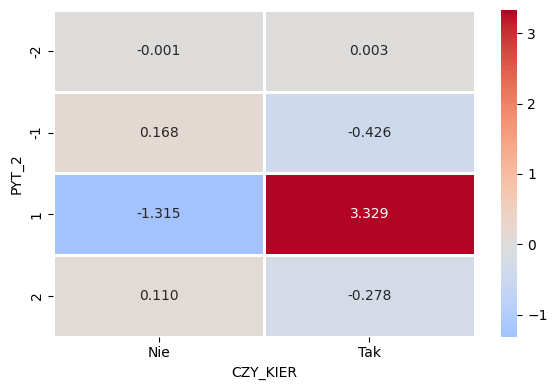

In [187]:
plt.figure(figsize=(6, 4))

sns.heatmap(
    chi2_P2CzK_stand_res,
    center=-0.05,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    cbar=True,
    xticklabels=crosstab_P2CzK.columns,
    yticklabels=crosstab_P2CzK.index,
    linewidths=1
)

plt.ylabel('PYT_2')
plt.xlabel('CZY_KIER')
plt.tight_layout()
plt.show()

Wykres przedstawia standaryzowane reszty, które wskazują, które kombinacje odpowiedzi występowały częściej lub rzadziej, niż przewidywano. Szczególnie widoczna jest silna dodatnia reszta dla odpowiedzi „Zdecydowanie się zgadzam” wśród osób zajmujących stanowiska kierownicze (ok. 3.33). Oznacza to, że ta kombinacja odpowiedzi występowała znacznie częściej, niż przewidywałby model niezależności. Z kolei największa ujemna reszta pojawia się w tej samej kategorii wśród osób niepełniących funkcji kierowniczych (ok. –1.32), co sugeruje, że zwykli pracownicy znacznie rzadziej odpowiadali „Zdecydowanie się zgadzam”, niż by to wynikało z oczekiwań.

Takie rozkłady standaryzowanych reszt sugerują istnienie statystycznie istotnej zależności między stopniem zadowolenia ze szkoleń a zajmowanym stanowiskiem, co potwierdził wcześniej test chi-kwadrat.

$\textbf{b)}$ CZY_ZADOW vs CZY_KIER

$H_0$: Zadowolenie ze szkoleń nie zależy od zajmowanego stanowiska

$H_1$: Zadowolenie ze szkoleń zależy od zajmowanego stanowiska

- Czy zadowolenie ze szkoleń zależy od zajmowanego stanowiska?

In [188]:
crosstab_CzZCzK = pd.crosstab(data['CZY_ZADOW'], data['CZY_KIER'])
chi2_CzZCzK = chi2_contingency(crosstab_CzZCzK.values)
pval_chi2_CzZ_CzK = chi2_CzZCzK.pvalue
print(f'p-wartość: {pval_chi2_CzZ_CzK:.4f}')

p-wartość: 0.9372


W tym przypadku przyjęto poziom istotności $\alpha = 0.01$. Porównując go z otrzymaną p-wartością:
$$ \text{p-wartość} \approx 0.94 > \alpha = 0.01$$
W związku z tym nie ma podstaw do odrzucenia hipotezy zerowej. Oznacza to, że stopień zadowolenia ze szkoleń nie jest statystycznie zależny od zajmowanego stanowiska.

Podobny wniosek został uzyskany w *Zadaniu 6 (test Fishera)*, gdzie również nie wykazano istotnej zależności między tymi zmiennymi.

- Wykres asocjacyjny

In [189]:
chi2_CzZCzK_stand_res = (crosstab_CzZCzK.values - chi2_CzZCzK.expected_freq) / np.sqrt(chi2_CzZCzK.expected_freq)

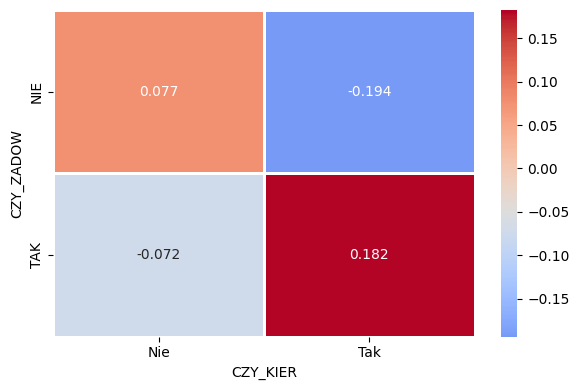

In [190]:
plt.figure(figsize=(6, 4))

sns.heatmap(
    chi2_CzZCzK_stand_res,
    center=-0.05,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    cbar=True,
    xticklabels=crosstab_CzZCzK.columns,
    yticklabels=crosstab_CzZCzK.index,
    linewidths=1
)

plt.ylabel('CZY_ZADOW')
plt.xlabel('CZY_KIER')
plt.tight_layout()
plt.show()

Analiza standaryzowanych reszt dla zmiennych „CZY_ZADOW” i „CZY_KIER” pokazuje, że wartości nie odbiegają istotnie od zera. Największa obserwowana różnica to $-0.194$ dla odpowiedzi „NIE” w grupie osób zajmujących stanowiska kierownicze. Jest to niewielkie odchylenie, co wskazuje, że ta odpowiedź wystąpiła nieco rzadziej niż przewidywano, jednak różnica jest znikoma.

W związku z tym model dobrze odwzorowuje obserwowane częstości, potwierdzając statystyczną niezależność badanych zmiennych.

### ZADANIE 9
    Zapoznaj się z funkcją służącą do generowania realizacji wektorów losowych z rozkładu wielomianowego, a następnie korzystając z niej przeprowadź symulacje w celu oszacowania mocy testu Fishera oraz mocy testu chi-kwadrat Pearsona, generując dane z tabeli 2×2, w której p11 = 1/40, p12 = 3/40, p21 = 19/40, p22 = 17/40. Symulacje wykonaj dla n = 50, n = 100 oraz n = 1000. Sformułuj wnioski.

In [191]:
p = [1/40, 3/40, 19/40, 17/40]
alpha = 0.05
tab_size = (2,2)
n = [50, 100, 1000]

In [192]:
def test_power(p, alpha, tab_size, n, M=500):
    chi2_rejected = 0
    fisher_rejected = 0
    for i in range(M):
        random_vector = np.random.multinomial(n, p)
        random_vector = random_vector.reshape(tab_size)
        try:
            chi2_results = chi2_contingency(random_vector)
            fisher_results = fisher_exact(random_vector)

            if chi2_results.pvalue < alpha:
                chi2_rejected += 1
            if fisher_results.pvalue < alpha:
                fisher_rejected += 1  
        except ValueError:
            continue
                     
    power_chi2 = chi2_rejected / M
    power_fisher = fisher_rejected / M

    return power_chi2, power_fisher

In [193]:
chi2_power = np.zeros(len(n))
fisher_power = np.zeros(len(n))

for i, n_i in enumerate(n):
    chi2_power[i], fisher_power[i] = test_power(p, alpha, tab_size, n_i)

In [194]:
data_test_power = {
    "n": n,
    "Moc testu chi-kwadrat": chi2_power,
    "Moc testu Fishera": fisher_power
}

df_test_power = pd.DataFrame(data_test_power)
df_test_power

,n,Moc testu chi-kwadrat,Moc testu Fishera
0,50,0.084,0.118
1,100,0.272,0.340
2,1000,1.000,1.000


Test chi-kwadrat oraz test Fishera wykazują porównywalną skuteczność w wykrywaniu zależności w danych, przy czym test Fishera charakteryzuje się nieco wyższą mocą w przypadku mniejszych prób. W związku z tym, przy niewielkiej liczebności próby warto rozważyć zastosowanie testu Fishera, który jest bardziej precyzyjny w takich warunkach. Natomiast dla większych próbek oba testy osiągają bardzo wysoką skuteczność, co znajduje odzwierciedlenie również na poniższym wykresie.

In [248]:
n_list = np.arange(50,1001,50)
chi2_power_list = np.zeros(len(n_list))
fisher_power_list = np.zeros(len(n_list))

for i, n_i in enumerate(n_list):
    chi2_power_list[i], fisher_power_list[i] = test_power(p, alpha, tab_size, n_i)

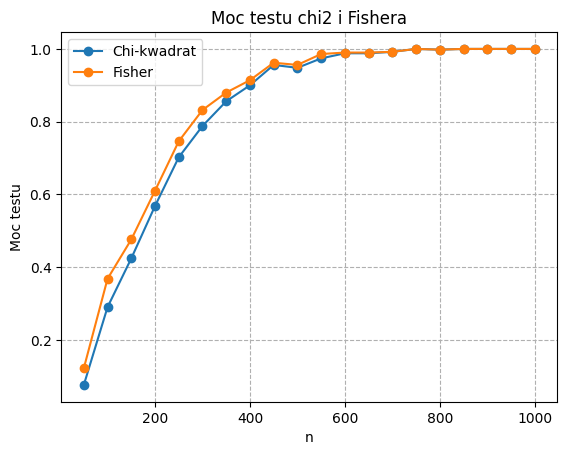

In [251]:
plt.plot(n_list, chi2_power_list, label='Chi-kwadrat', marker='o')
plt.plot(n_list, fisher_power_list, label='Fisher', marker='o')

plt.legend()
plt.title('Moc testu chi2 i Fishera')
plt.grid(True, linestyle='--')
plt.xlabel('n')
plt.ylabel('Moc testu')
plt.show()

### ZADANIE 10
    Napisz funkcję, która dla danych z tablicy dwudzielczej oblicza wartość poziomu krytycznego w teście niezależnosci opartym na ilorazie wiarogodnosci. Korzystając z napisanej funkcji, wykonaj test dla danych przeanalizowanych w zadaniu 8.

W zadaniu zastosowano wbudowaną funkcję *chi2_contingency* z pakietu *scipy.stats*, która po ustawieniu parametru **lambda_="log-likelihood"** wykonuje test niezależności oparty na ilorazie wiarygodności, znany również jako test G.

In [196]:
def likelihood_ratio_test_g(obs):
    stat, p, dof, _ = chi2_contingency(obs, lambda_="log-likelihood")
    return stat, p, dof

Przedstawiony test wykonamy dla danych przeanalizowanych w zadaniu 8

$\textbf{a)}$ PYT_2 vs CZY_KIER

In [197]:
stat, pval_gtest_P2_CzK, dof = likelihood_ratio_test_g(crosstab_P2CzK.values)

print(f"Statystyka G: {stat:.4f}, p-value: {pval_gtest_P2_CzK:.4f}, stopnie swobody: {dof}")

Statystyka G: 8.3285, p-value: 0.0397, stopnie swobody: 3


Przyjmując poziom istotności $\alpha = 0.01$, otrzymano wynik:
$$\text{p-wartość} = 0.0397 > \alpha=0.01$$
Oznacza to, że nie ma podstaw do odrzucenia hipotezy zerowej, zakładającej brak związku pomiędzy stopniem zadowolenia ze szkoleń a zajmowanym stanowiskiem.

Wynik ten różni się od rezultatu uzyskanego w zadaniu 8, gdzie test wskazywał na istotną zależność przy tym samym poziomie istotności ($\alpha = 0.01$). Różnica ta może wynikać z odmiennych założeń i konstrukcji zastosowanych testów: test chi-kwadrat Pearsona (użyty w zadaniu 8) i test ilorazu wiarygodności (G-test) mogą dawać różne wyniki, zwłaszcza przy mniejszych próbach lub bardziej rozproszonych danych.

Warto zauważyć, że przy poziomie istotności $\alpha = 0.05$, test G wskazuje na istotność zależności, ponieważ $0.0397 < \alpha=0.05$. Oznacza to, że decyzja o odrzuceniu lub nieodrzuceniu hipotezy zerowej zależy od przyjętego poziomu istotności, co podkreśla konieczność jego jasnego ustalenia na początku analizy.

$\textbf{b)}$ CZY_ZADOW vs CZY_KIER

In [198]:
stat,  pval_gtest_CzZ_CzK, dof = likelihood_ratio_test_g(crosstab_CzZCzK.values)

print(f"Statystyka G: {stat:.4f}, p-value: { pval_gtest_CzZ_CzK:.4f}, stopnie swobody: {dof}")

Statystyka G: 0.0062, p-value: 0.9372, stopnie swobody: 1


Przyjmując poziom istotności $\alpha = 0.01$, otrzymano wynik:
$$\text{p-wartość} \approx 0.94 > \alpha=0.01$$
Wartość p wyraźnie przekracza przyjęty poziom istotności, co oznacza brak podstaw do odrzucenia hipotezy zerowej. Tym samym nie stwierdzono statystycznie istotnej zależności między zadowoleniem ze szkoleń a zajmowanym stanowiskiem.

Uzyskany wynik jest spójny z rezultatem z zadania 8, gdzie również, przy tym samym poziomie istotności, nie wykazano istnienia związku między analizowanymi zmiennymi.

-----
Dla większej przejrzystości i ułatwienia porównania, zestawiono omówione wyniki w formie tabeli. Umożliwia to szybkie porównanie rezultatów obu testów (test chi-kwadrat i test G) dla różnych poziomów istotności.

In [199]:
# Analiza: PYT_2 vs CZY_KIER
reject_chi2_P2_CzK = "Tak" if pval_chi2_P2_CzK < alpha else "Nie"
reject_gtest_P2_CzK = "Tak" if pval_gtest_P2_CzK < alpha else "Nie"

# Analiza: CZY_ZADOW vs CZY_KIER
reject_chi2_CzZ_CzK = "Tak" if pval_chi2_CzZ_CzK < alpha else "Nie"
reject_gtest_CzZ_CzK = "Tak" if pval_gtest_CzZ_CzK < alpha else "Nie"

results = [
    {
        "Tablica dwudzielcza": "PYT_2 vs CZY_KIER",
        "Test": "Chi-kwadrat Pearsona",
        "p-wartość": pval_chi2_P2_CzK,
        "H₀ odrzucona (α=0.01)": "Tak" if pval_chi2_P2_CzK < 0.01 else "Nie",
        "H₀ odrzucona (α=0.05)": "Tak" if pval_chi2_P2_CzK < 0.05 else "Nie"
    },
    {
        "Tablica dwudzielcza": "PYT_2 vs CZY_KIER",
        "Test": "G-test (iloraz wiarygodności)",
        "p-wartość": pval_gtest_P2_CzK,
        "H₀ odrzucona (α=0.01)": "Nie" if pval_gtest_P2_CzK >= 0.01 else "Tak",
        "H₀ odrzucona (α=0.05)": "Tak" if pval_gtest_P2_CzK < 0.05 else "Nie"
    },
    {
        "Tablica dwudzielcza": "CZY_ZADOW vs CZY_KIER",
        "Test": "Chi-kwadrat Pearsona",
        "p-wartość": pval_chi2_CzZ_CzK,
        "H₀ odrzucona (α=0.01)": "Nie" if pval_chi2_CzZ_CzK >= 0.01 else "Tak",
        "H₀ odrzucona (α=0.05)": "Nie" if pval_chi2_CzZ_CzK >= 0.05 else "Tak"
    },
    {
        "Tablica dwudzielcza": "CZY_ZADOW vs CZY_KIER",
        "Test": "G-test (iloraz wiarygodności)",
        "p-wartość": pval_gtest_CzZ_CzK,
        "H₀ odrzucona (α=0.01)": "Nie" if pval_gtest_CzZ_CzK >= 0.01 else "Tak",
        "H₀ odrzucona (α=0.05)": "Nie" if pval_gtest_CzZ_CzK >= 0.05 else "Tak"
    }
]

df_8vs10 = pd.DataFrame(results)
df_8vs10


,Tablica dwudzielcza,Test,p-wartość,H₀ odrzucona (α=0.01),H₀ odrzucona (α=0.05)
0,PYT_2 vs CZY_KIER,Chi-kwadrat Pearsona,0.004397,Tak,Tak
1,PYT_2 vs CZY_KIER,G-test (iloraz wiarygodności),0.039690,Nie,Tak
2,CZY_ZADOW vs CZY_KIER,Chi-kwadrat Pearsona,0.937213,Nie,Nie
3,CZY_ZADOW vs CZY_KIER,G-test (iloraz wiarygodności),0.937197,Nie,Nie


## CZĘŚĆ IV i V

### ZADANIE 11
    Przeprowadzone wsród brytyjskich mężczyzn badanie trwające 20 lat wykazało, że odsetek zmarłych (na rok) z powodu raka płuc wynosił 0,00140 wsród osób palących papierosy i 0,00010 wsród osób niepalących. Odsetek zmarłych z powodu choroby niedokrwiennej serca wynosił 0,00669 dla palaczy i 0,00413 dla osób niepalących. Opisz związek pomiędzy paleniem papierosów a śmiercią z powodu raka płuc oraz związek pomiędzy paleniem papierosów a śmiercią z powodu choroby serca. Skorzystaj z różnicy proporcji, ryzyka względnego i ilorazu szans. Zinterpretuj wartości. Związek której pary zmiennych jest silniejszy?

Skorzystamy z następujących definicji:

- Ryzyko względne (RR): porównuje prawdopodobieństwo wystąpienia danego zdarzenia w grupie badanej (interwencyjnej) do grupy kontrolnej

$$
RR = \dfrac{IE/(IE + IN)}{CE/(CE + CN)}
$$

gdzie: 

$RR$ - ryzyko względne, 	

$IE$ - liczba przypadków zdarzenia w grupie interwencyjnej,

$IN$ - liczba przypadków braku zdarzenia w grupie interwencyjnej,

$CE$ - liczba przypadków zdarzenia w grupie kontrolnej,

$CN$ - liczba przypadków braku zdarzenia w grupie kontrolnej.

Wyniki można interpretować następująco:

RR > 1: ryzyko wystąpienia zdarzenia jest większe w grupie interwencyjnej niż w kontrolnej,

RR < 1: ryzyko wystąpienia zdarzenia jest mniejsze w grupie interwencyjnej,

RR = 1: brak różnicy pomiędzy grupami.

- Iloraz szans (ang. OR, odds ratio): stosunek szans wystąpienia danego zdarzenia w jednej grupie do szansy jego wystąpienia w innej grupie

$$
OR_{A/B} = \dfrac{\mathbb {P}(A)\cdot(1-\mathbb {P}(B))}{\mathbb {P}(B)\cdot(1-\mathbb {P}(A))}
$$

gdzie: $\mathbb {P}(A)$ to prawdopodobieństwo wystąpienia zdarzenia w grupie $A$.

Wyniki można interpretować następująco:

OR > 1: wyższe szanse wystąpienia zdarzenia w grupie A względem grupy B,

OR < 1: niższe szanse wystąpienia zdarzenia w grupie A,

OR = 1: brak różnicy w szansach między grupami.

In [200]:
# Odsetek zmarłych z powodu raka płuc wśród palaczy i niepalaczy
lung_cancer_rate_smokers = 0.00140
lung_cancer_rate_nonsmokers  = 0.00010

lung_cancer_rate_diff = lung_cancer_rate_smokers - lung_cancer_rate_nonsmokers
lung_cancer_RR = lung_cancer_rate_smokers / lung_cancer_rate_nonsmokers
lung_cancer_OR = (lung_cancer_rate_smokers / (1 - lung_cancer_rate_smokers)) / (lung_cancer_rate_nonsmokers / (1 - lung_cancer_rate_nonsmokers))

# Odsetek zmarłych z powodu choroby niedokrwiennej serca wśród palaczy i niepalaczy
heart_disease_rate_smokers = 0.00669
heart_disease_rate_nonsmokers = 0.00413

heart_disease_rate_diff = heart_disease_rate_smokers - heart_disease_rate_nonsmokers
heart_disease_RR = heart_disease_rate_smokers / heart_disease_rate_nonsmokers
heart_disease_OR = (heart_disease_rate_smokers / (1 - heart_disease_rate_smokers)) / (heart_disease_rate_nonsmokers / (1 - heart_disease_rate_nonsmokers))

In [201]:
data_british_man = {
    "Choroba": ["Rak płuc", "Choroba niedokrwienna serca"],
    "Odsetek zmarłych (palacze)": [lung_cancer_rate_smokers, heart_disease_rate_smokers],
    "Odsetek zmarłych (niepalacze)": [lung_cancer_rate_nonsmokers, heart_disease_rate_nonsmokers],
    "Różnica proporcji": [lung_cancer_rate_diff, heart_disease_rate_diff],
    "Ryzyko względne (RR)": [lung_cancer_RR, heart_disease_RR],
    "Iloraz szans (OR)": [lung_cancer_OR, heart_disease_OR]
}

df_british_man = pd.DataFrame(data_british_man)
df_british_man["Odsetek zmarłych (palacze)"] = df_british_man["Odsetek zmarłych (palacze)"].apply(lambda x: f"{x:.4f}")
df_british_man["Odsetek zmarłych (niepalacze)"] = df_british_man["Odsetek zmarłych (niepalacze)"].apply(lambda x: f"{x:.4f}")
df_british_man["Różnica proporcji"] = df_british_man["Różnica proporcji"].apply(lambda x: f"{x:.4f}")
df_british_man["Ryzyko względne (RR)"] = df_british_man["Ryzyko względne (RR)"].apply(lambda x: f"{x:.2f}")
df_british_man["Iloraz szans (OR)"] = df_british_man["Iloraz szans (OR)"].apply(lambda x: f"{x:.2f}")

df_british_man

,Choroba,Odsetek zmarłych (palacze),Odsetek zmarłych (niepalacze),Różnica proporcji,Ryzyko względne (RR),Iloraz szans (OR)
0,Rak płuc,0.0014,0.0001,0.0013,14.00,14.02
1,Choroba niedokrwienna serca,0.0067,0.0041,0.0026,1.62,1.62


Analizując otrzymane wyniki:

a) Rak płuc

Na podstawie różnicy proporcji można stwierdzić, że osoby palące charakteryzują się wyraźnie wyższą zachorowalnością na raka płuc w porównaniu do osób niepalących – różnica ta wynosi około 0.13%.

Dodatkowo, wartość ryzyka względnego wynosząca RR = 14 oznacza, że ryzyko zachorowania na raka płuc wśród palaczy jest 14 razy wyższe niż wśród osób niepalących. Podobnie, iloraz szans OR = 14.02 również wskazuje na znacznie wyższe szanse wystąpienia choroby w grupie palaczy.

Otrzymane wyniki są zgodne z intuicją oraz dotychczasową wiedzą medyczną – palenie papierosów znacząco zwiększa ryzyko zachorowania na raka płuc.

b) Choroba niedokrwienia serca

W przypadku choroby niedokrwiennej serca zaobserwowano mniejszą, lecz nadal zauważalną zależność pomiędzy paleniem a zachorowalnością. Różnica proporcji wynosi 0.26%, co oznacza, że osoby palące częściej chorują na niedokrwienie serca niż osoby niepalące.

Jednakże wartości ryzyka względnego i ilorazu szans (RR = 1.62, OR = 1.62) wskazują, że zależność ta jest znacznie słabsza niż w przypadku raka płuc. Oznacza to, że średnie ryzyko zachorowania na chorobę niedokrwienną serca wśród palaczy jest około 1.6 razy wyższe niż u niepalących.

### ZADANIE 12
    Tabela 1 przedstawia wyniki dotyczące śmiertelności kierowców i pasażerów w wypadkach samochodowych na Florydzie w 2008 roku, w zależności od tego, czy osoba miała zapięty pas bezpieczeństwa czy nie.

<div align="center">

| | Śmiertelny | Nieśmiertelny |
| ----------- | ----------- | ----------- |
| **Bez pasów** | 1085 | 55 623 |
| **Z pasami** | 703 | 441 239 |

</div> 
<br>
<div align="center">
Table 1: Wyniki dotyczące śmiertelności w wypadkach samochodowych na Florydzie w 2008 roku.
</div>

        a) Oszacuj warunkowe prawdopodobieństwo śmierci w wypadku ze względu na drugą zmienną, tj. dla kierowców i pasażerów, którzy użyli pasa bezpieczeństwa oraz dla kierowców i pasażerów, który nie użyli pasa bezpieczeństwa.
        b) Oszacuj warunkowe prawdopodobieństwo użycia pasa bezpieczeństwa ze względu na drugą zmienną, tj. dla kierowców i pasażerów ze śmiertelnymi obrażeniami oraz dla kierowców i pasażerów, którzy przeżyli wypadek.
        c) Jaki jest najbardziej naturalny wybór dla zmiennej objaśnianej w tym badaniu? Dla takiego wyboru wyznacz i zinterpretuj różnice proporcji, ryzyko względne oraz iloraz szans. Dlaczego wartości ryzyka względnego i ilorazu szans przyjmują zbliżone wartości?

In [202]:
#dead
death_with_belts = 703
death_no_belts = 1085
total_death = death_with_belts + death_no_belts

#alive
alive_with_belts = 441239
alive_no_belts = 55623
total_alive = alive_with_belts + alive_no_belts

#total
total = total_death + total_alive

$\textbf{a)}$ Warunkowe prawdopodobieństwo śmierci w zależności od użycia pasów bezpieczeństwa

In [203]:
# pod warunkiem użycia pasów
cond_prob_death_with_belts = death_with_belts / (death_with_belts + alive_with_belts)
print(f"Prawdopodobieństwo śmierci pod warunkiem użycia pasów bezpieczeństwa: {cond_prob_death_with_belts:.4f}")

# pod warunkiem nieużycia pasów
cond_prob_death_no_belts = death_no_belts / (death_no_belts + alive_no_belts)
print(f"Prawdopodobieństwo śmierci pod warunkiem nieużycia pasów bezpieczeństwa: {cond_prob_death_no_belts:.3f}")

Prawdopodobieństwo śmierci pod warunkiem użycia pasów bezpieczeństwa: 0.0016
Prawdopodobieństwo śmierci pod warunkiem nieużycia pasów bezpieczeństwa: 0.019


Zgodnie ze zdroworozsądkowym założeniem, stosowanie pasów bezpieczeństwa powinno obniżać ryzyko śmierci w wypadkach drogowych. Wyniki potwierdzają tę hipotezę. Prawdopodobieństwo śmierci pod warunkiem użycia pasów bezpieczeństwa wynosi 0.0016, podczas gdy pod warunkiem nieużycia pasów bezpieczeństwa wynosi już 0.019.

$\textbf{b)}$ Warunkowe prawdopodobieństwo użycia pasów w zależności od wyniku wypadku

In [204]:
# pod warunkiem użycia pasów
cond_prob_with_belts_death = death_with_belts / (death_with_belts + death_no_belts)
print(f"Prawdopodobieństwo użycia pasów bezpieczeństwa pod warunkiem śmierci: {cond_prob_with_belts_death:.3f}")

# pod warunkiem użycia pasów
cond_prob_no_belts_alive = alive_with_belts / (alive_with_belts + alive_no_belts)
print(f"Prawdopodobieństwo użycia pasów bezpieczeństwa po warunkiem przeżycia: {cond_prob_no_belts_alive:.3f}")

Prawdopodobieństwo użycia pasów bezpieczeństwa pod warunkiem śmierci: 0.393
Prawdopodobieństwo użycia pasów bezpieczeństwa po warunkiem przeżycia: 0.888


Rozpatrując sytuację odwrotnie, można oszacować, jak fakt przeżycia lub śmierci wpływa na prawdopodobieństwo użycia pasów bezpieczeństwa. Prawdopodobieństwo użycia pasów wśród osób, które przeżyły wynosi 0.888. Prawdopodobieństwo użycia pasów wśród osób, które zginęły: 0.393

Zatem osoby, które przeżyły wypadek, znacznie częściej (ponad dwukrotnie częściej) miały zapięte pasy w porównaniu do tych, które poniosły śmierć.

$\textbf{c)}$ Zmienna objaśniana i miary efektu

Najbardziej naturalnym wyborem dla zmiennej objaśnianej jest stan osoby po wypadku, a zmiennej objaśniającej – użycie pasów bezpieczeństwa. Taki wybór pomoże zbadać wpływ stosowania pasów na ryzyko śmierci.

- różnica proporcji

In [205]:
death_belts_prop_diff = cond_prob_death_no_belts - cond_prob_death_with_belts 
print(f"Różnica proporcji prawdopodobieństwa śmierci: {death_belts_prop_diff:.4f}")

Różnica proporcji prawdopodobieństwa śmierci: 0.0175


Oznacza to, że brak pasów zwiększa ryzyko śmierci o $1.75 \%$.

- ryzyko względne (RR)

In [206]:
death_belts_RR = cond_prob_death_no_belts / cond_prob_death_with_belts
print(f"Ryzyko względne (RR) śmierci: {death_belts_RR:.2f}")

Ryzyko względne (RR) śmierci: 12.03


Osoby bez pasów są około 12 razy bardziej narażone na śmierć niż osoby z zapiętymi pasami.

- iloraz szans (OR)

In [207]:
death_belts_OR = (cond_prob_death_no_belts / (1 - cond_prob_death_no_belts)) / (cond_prob_death_with_belts / (1 - cond_prob_death_with_belts))
print(f"Iloraz szans (OR) śmierci: {death_belts_OR:.2f}")

Iloraz szans (OR) śmierci: 12.24


Zarówno RR, jak i OR mają zbliżone wartości (ok. 12), co jest typowe dla rzadkich zdarzeń (takich jak śmierć w wypadku), ponieważ w takich przypadkach szanse i prawdopodobieństwa przyjmują podobne wartości, a różnice między nimi są minimalne.

### ZADANIE 13
    Oblicz wartości odpowiednich miar współzmienności (współczynnik tau lub współczynnik gamma) dla zmiennych:
        • stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie i zajmowane stanowisko,
        • stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie i staż pracy,
        • zajmowane stanowisko i staż pracy.

Funkcje do obliczania współczynnika tau oraz współczynnika gamma zostały zaimplementowane z wykorzystaniem integracji środowisk Python i R, korzystając z funkcji *GoodmanKruskalTau* oraz *GoodmanKruskalGamma* z pakietu *DescTools*.

In [ ]:
from rpy2.robjects import pandas2ri

def tau_goodman_kruskal(datax,datay):
    DescTools = importr('DescTools')
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_x = ro.conversion.py2rpy(datax)
        r_y = ro.conversion.py2rpy(datay)
    
    tau_gk = DescTools.GoodmanKruskalTau(r_x, r_y)
    return tau_gk[0]

In [268]:
def gamma_goodman_kruskal(datax, datay):
    DescTools = importr('DescTools')
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_x = ro.conversion.py2rpy(datax)
        r_y = ro.conversion.py2rpy(datay)

    gamma_gk = DescTools.GoodmanKruskalGamma(r_x, r_y)
    
    return gamma_gk[0]

- stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie i zajmowane stanowisko

In [269]:
tau_gk_P2CzK = tau_goodman_kruskal(data['PYT_2'], data['CZY_KIER'])
gamma_gk_P2CzK = gamma_goodman_kruskal(data['PYT_2'], data['CZY_KIER'])

- stopień zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie i staż pracy

In [270]:
tau_gk_P2S = tau_goodman_kruskal(data['PYT_2'], data['STAŻ'])
gamma_gk_P2S = gamma_goodman_kruskal(data['PYT_2'], data['STAŻ'])

- zajmowane stanowisko i staż pracy

In [271]:
tau_gk_CzKS = tau_goodman_kruskal(data['CZY_KIER'], data['STAŻ'])
gamma_gk_CzKS = gamma_goodman_kruskal(data['CZY_KIER'], data['STAŻ'])

In [272]:
results = pd.DataFrame({
    "Zmienne": [
        "PYT_2 vs CZY_KIER",
        "PYT_2 vs STAŻ",
        "CZY_KIER vs STAŻ"
    ],
    "Goodman-Kruskal Tau": [
        tau_gk_P2CzK,
        tau_gk_P2S,
        tau_gk_CzKS
    ],
    "Goodman-Kruskal Gamma": [
        gamma_gk_P2CzK,
        gamma_gk_P2S,
        gamma_gk_CzKS
    ]
})

round(results,3)

,Zmienne,Goodman-Kruskal Tau,Goodman-Kruskal Gamma
0,PYT_2 vs CZY_KIER,0.002,-0.034
1,PYT_2 vs STAŻ,0.019,0.091
2,CZY_KIER vs STAŻ,0.116,0.753


Interpretacja wyników miar współzmienności Goodman-Kruskal Tau oraz Gamma:

1. Zależność między stopniem zadowolenia ze szkoleń (PYT_2) a zajmowanym stanowiskiem (CZY_KIER):

Wartości miar są bardzo niskie (Tau ≈ 0.002, Gamma ≈ -0.034), co wskazuje na brak istotnej monotonicznej zależności między oceną szkoleń a pełnioną funkcją kierowniczą. Oznacza to, że stopień zadowolenia ze szkoleń nie różni się znacząco między kierownikami, a zwykłymi pracownikami.

2. Zależność między stopniem zadowolenia ze szkoleń (PYT_2) a stażem pracy (STAŻ):

Miary wskazują na bardzo słabą dodatnią zależność (Tau = 0.019, Gamma = 0.091). To sugeruje, że długość stażu pracy ma minimalny wpływ na ocenę szkoleń — pracownicy z różnym stażem mogą bardzo podobnie oceniać szkolenia.

3. Zależność między zajmowanym stanowiskiem (CZY_KIER) a stażem pracy (STAŻ):

Tutaj wartości są zdecydowanie wyższe. Tau = 0.116 świadczy o słabej zależności kierunkowej, nastomiast Gamma = 0.753 świadczy już o silnej dodatniej zależności. Oznacza to, że pracownicy na stanowiskach kierowniczych przeważnie mają dłuższy staż pracy, a krótszy staż jest bardziej charakterystyczny dla pracowników niezajmujących stanowisk kierowniczych.

### ZADANIE 14
    Na podstawie informacji przedstawionych na wykładzie napisz własną funkcję do przeprowadzania analizy korespondencji. Funkcja powinna przyjmować jako argument tablicę dwudzielczą i zwracać obliczone wartości odpowiednich wektorów i macierzy, współrzędnych punktów oraz odpowiedni wykres. Korzystając z napisanej funkcji wykonaj analizę korespondencji dla danych dotyczących stopnia zadowolenia ze szkoleń w kontekście dopasowania do indywidualnych potrzeb w pierwszym badanym okresie oraz stażu pracy.

Analiza korespondencji to opisowo-eksploracyjna metoda statystyczna służąca do analizy danych przedstawionych w tabelach kontyngencji (np. dwuwymiarowych), której celem jest identyfikacja i wizualizacja zależności oraz podobieństw między kategoriami wierszy i kolumn.

In [273]:
def correspondence_analysis(crosstab):    
    freq_tab = crosstab.values / np.sum(crosstab.values)
    r = freq_tab.sum(axis=1)
    c = freq_tab.sum(axis=0)

    #macierz profili wierszowych i kolumnowych
    row_profiles = freq_tab / r.reshape(-1, 1)
    col_profiles = freq_tab / c.reshape(1, -1)

    #macierze częstości wierszowych i kolumnowych
    Dr, Dc = np.diag(r), np.diag(c)
    
    #macierz residuów standaryzowanych A (dekompozycja SVD)
    rc = r.reshape(-1, 1) @ c.reshape(1, -1)
    A = np.sqrt(linalg.inv(Dr)) @ (freq_tab - rc) @ np.sqrt(linalg.inv(Dc))
    U, singular_values, VT = linalg.svd(A, full_matrices=False)

    #macierze współrzędnych kategorii cech
    F = np.sqrt(linalg.inv(Dr)) @ U @ np.diag(singular_values)  #wiersz
    G = np.sqrt(linalg.inv(Dc)) @ VT.T @ np.diag(singular_values)   #kolumna


    plt.figure(figsize=(6, 4))
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

    # Wiersze
    plt.scatter(F[:, 0], F[:, 1], c='blue', label='Wiersze')
    for i, label in enumerate(crosstab.index):
        plt.text(F[i, 0] - 0.06, F[i, 1], label, color='blue', ha='right', va='top')

    # Kolumny
    plt.scatter(G[:, 0], G[:, 1], c='red', marker='^', label='Kolumny')
    for j, label in enumerate(crosstab.columns):
        plt.text(G[j, 0], G[j, 1] + 1.8e-18, label, color='red', ha='left', va='bottom')

    plt.xlabel("Wymiar 1")
    plt.ylabel("Wymiar 2")
    plt.title("Analiza korespondencji (principal)")
    plt.legend()

    plt.show()

    results = {
        "Macierz korespondencji": pd.DataFrame(freq_tab, index=crosstab.index, columns=crosstab.columns),
        "Wektor częstości brzegowych (wiersze)": pd.Series(r, index=crosstab.index),
        "Wektor częstości brzegowych (kolumny)": pd.Series(c, index=crosstab.columns),
        "Macierz profili wierszowych": pd.DataFrame(row_profiles, index=crosstab.index, columns=crosstab.columns),
        "Macierz profili kolumnowych": pd.DataFrame(col_profiles, index=crosstab.index, columns=crosstab.columns),
        "Macierz współrzędnych (wiersze)": pd.DataFrame(F, index=crosstab.index, columns=["Wymiar 1", "Wymiar 2", "Wymiar 3"]),
        "Macierz współrzędnych (kolumny)": pd.DataFrame(G, index=crosstab.columns, columns=["Wymiar 1", "Wymiar 2", "Wymiar 3"])
    }

    return results

In [274]:
crosstab_P2S = pd.crosstab(data['PYT_2'], data['STAŻ'])

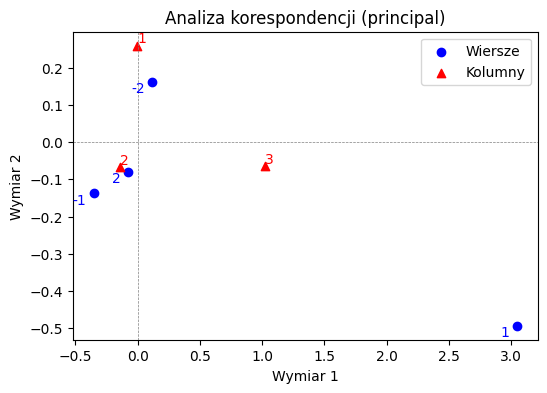


--- Macierz korespondencji ---

STAŻ       1      2      3
PYT_2                     
-2     0.100  0.225  0.045
-1     0.015  0.085  0.000
 1     0.000  0.000  0.010
 2     0.090  0.390  0.040

--- Wektor częstości brzegowych (wiersze) ---

PYT_2
-2    0.37
-1    0.10
 1    0.01
 2    0.52
dtype: float64

--- Wektor częstości brzegowych (kolumny) ---

STAŻ
1    0.205
2    0.700
3    0.095
dtype: float64

--- Macierz profili wierszowych ---

STAŻ        1       2       3
PYT_2                        
-2     0.2703  0.6081  0.1216
-1     0.1500  0.8500  0.0000
 1     0.0000  0.0000  1.0000
 2     0.1731  0.7500  0.0769

--- Macierz profili kolumnowych ---

STAŻ        1       2       3
PYT_2                        
-2     0.4878  0.3214  0.4737
-1     0.0732  0.1214  0.0000
 1     0.0000  0.0000  0.1053
 2     0.4390  0.5571  0.4211

--- Macierz współrzędnych (wiersze) ---

       Wymiar 1  Wymiar 2  Wymiar 3
PYT_2                              
-2       0.1183    0.1622      -0.0
-1   

In [275]:
results = correspondence_analysis(crosstab_P2S)

for key, value in results.items():
    print(f"\n--- {key} ---\n")
    print(value.round(4))

Analiza korespondencji dla zmiennych PYT_2 ("Ocena dostosowania szkoleń do indywidualnych potrzeb pracownika") oraz STAŻ ("Jak długo pracujesz w firmie?")

$\textbf{a)}$ Macierz korespondencji

Rozkład odpowiedzi wskazuje, że najczęściej wybieraną kombinacją była odpowiedź „Zdecydowanie się zgadzam” (PYT_2 = 2) udzielona przez pracowników ze stażem od 1 do 3 lat (STAŻ = 2) – stanowiła ona 39% wszystkich odpowiedzi.

$\textbf{b)}$ Wektor częstości brzegowych (wiersze)

Rozkład odpowiedzi na pytanie PYT_2 wygląda następująco:

- 52% respondentów wybrało odpowiedź 2 („Zdecydowanie się zgadzam”),

- 37% wskazało odpowiedź -2 („Zdecydowanie się nie zgadzam”),

- tylko 1% respondentów wybrało odpowiedź 1 („Zgadzam się”),

- 10% wybrało odpowiedź -1 („Nie zgadzam się”).

$\textbf{c)}$ Wektor częstości brzegowych (kolumny)

Pod względem długości stażu:

- 20.5% respondentów pracuje krócej niż rok (STAŻ = 1),

- 70% ma staż między jednym a trzema latami (STAŻ = 2),

- 9.5% pracuje powyżej 3 lat (STAŻ = 3).

Wyniki te wskazują, że w badaniu dominują pracownicy z krótszym i średnim stażem, a grupa z najdłuższym stażem jest najmniej liczna.

$\textbf{d)}$ Macierz profili wierszowych

Zawiera częstości odpowiedzi na pytanie o długość stażu ze względu na odpowiedź na pytanie o stopień zadowolenia ze szkoleń. Na przykład:

- Wśród osób wybierających -2 („Zdecydowanie się nie zgadzam”) aż 60.8% to pracownicy z stażem między jednym a trzema latami,

- W grupie respondentów wybierających odpowiedź -1, liczba osób ze stażem między jednym a trzema latami (STAŻ = 2) jest ponad pięciokrotnie większa niż liczba osób z stażem poniżej roku (STAŻ = 1).

$\textbf{e)}$ Macierz profili kolumnowych

Zawiera częstości odpowiedzi na pytanie o stopień zadowolenia ze szkoleń ze względu na odpowiedź na pytanie o długość stażu. Na przykład:

- Pracownicy ze stażem krótszym niż rok (STAŻ=1) najczęściej wybierają odpowiedź -2 („Zdecydowanie się nie zgadzam”) - 48.8% oraz 2 („Zdecydowanie się zgadzam”) - 43.9%,

- Pracownicy ze stażem między jednym a trzema latami (STAŻ = 2) wybierają odpowiedź „Zdecydowanie się zgadzam” ponad czterokrotnie częściej niż odpowiedź „Nie zgadzam się”.

-------------------------------------------------------

## ZADANIA DODATKOWE

### ZADANIE *1
    Napisz funkcję, która dla dwóch wektorów danych oblicza wartość poziomu krytycznego (p-value) w teście opartym na korelacji odległości. Następnie dla wygenerowanych danych zweryfikuj hipotezę o niezależności przy użyciu napisanej funkcji.

**Korelacja odległości (distance correlation)** jest miarą zależności między zmiennymi losowymi, która – w odróżnieniu od klasycznego współczynnika korelacji Pearsona – wykrywa zarówno zależności liniowe, jak i nieliniowe. Wartość korelacji odległości wynosi zero wtedy i tylko wtedy, gdy zmienne są niezależne. Jest to zatem silne narzędzie statystyczne do testowania hipotezy niezależności.

Aby zweryfikować hipotezę:

- $ H_0 $: zmienne X i Y są niezależne,  
- $ H_1 $: zmienne X i Y są zależne,

stosowany jest **test permutacyjny**, który polega na porównaniu wartości obserwowanej statystyki korelacji odległości z rozkładem tej statystyki uzyskanym poprzez wielokrotne losowe permutowanie jednej ze zmiennych. Wartość p oblicza się jako stosunek liczby permutacji, dla których permutowana statystyka była większa lub równa statystyce obserwowanej, do liczby wszystkich permutacji.


In [276]:
from scipy.spatial.distance import pdist, squareform

def distance_matrix(X):
    return squareform(pdist(X[:, None] if X.ndim == 1 else X, metric='euclidean'))

def double_centered(A):
    n = A.shape[0]
    row_mean = A.mean(axis=1, keepdims=True)
    col_mean = A.mean(axis=0, keepdims=True)
    total_mean = A.mean()
    return A - row_mean - col_mean + total_mean

def distance_covariance(X, Y):
    A = double_centered(distance_matrix(X))
    B = double_centered(distance_matrix(Y))
    return np.mean(A * B)

def distance_correlation(X, Y):
    dcov_xy = distance_covariance(X, Y)
    dcov_xx = distance_covariance(X, X)
    dcov_yy = distance_covariance(Y, Y)
    if dcov_xx == 0 or dcov_yy == 0:
        return 0
    return np.sqrt(dcov_xy) / np.sqrt(np.sqrt(dcov_xx * dcov_yy))

def distance_correlation_test(X, Y, num_permutations=1000, seed=None):
    np.random.seed(seed)
    observed = distance_correlation(X, Y)
    count = 0
    for _ in range(num_permutations):
        permuted_Y = np.random.permutation(Y)
        permuted_corr = distance_correlation(X, permuted_Y)
        if permuted_corr >= observed:
            count += 1
    p_value = count / num_permutations
    return observed, p_value

In [277]:
np.random.seed(0)
n = 100
X = np.random.normal(0, 1, n)
Y = X**2 + np.random.normal(0, 1, n)  # nieliniowa zależność

stat, p_val = distance_correlation_test(X, Y, num_permutations=1000)
print(f"Korelacja odległości: {stat}")
print(f"P-value: {p_val}")


Korelacja odległości: 0.40269666862692627
P-value: 0.001


### ZADANIE *2
    Dla zadanych π1 oraz π2 pokaż, że wartość ryzyka względnego (RR) nie jest bardziej oddalona od wartości 1 (wartość odpowiadająca niezależności) niż wartość odpowiadającego ilorazu szans (OR).

### ZADANIE *3
    Niech D oznacza posiadanie pewnej choroby, a E pozostawanie wystawionym na pewny czynnik ryzyka. W badaniach epidemiologicznych definuje się miarę AR nazywaną ryzykiem przypisanym (ang. attributable risk).
        a) Niech P(E′) = 1−P(E), wówczas AR = [P(D)−P(D|E′)]/P(D). Wyjaśnij interpretację miary na podstawie wzoru.
        b) Pokaż, że AR ma związek z ryzykiem względnym, tzn.:
                AR=[P(E)(RR−1)]/[1+P(E)(RR−1)]